# Exercise 2

## Group
- **ID**: 5

- **Members**:
    - Hasan Algafri
    - Emre Dursunluer
    - Taha El Amine Kassabi

## Hand-in
- Please hand in this notebook with your code implementation via Ilias
- Please make sure that there is exactly **one** submission per group

## Task Description

Write a custom fused ReLU class for 2D tensors, that implements **vector addition and ReLU**, with the **forward** pass. Then write a fused ReLU Triton kernel for 2D tensors that performs the **vector addition and ReLU** with the **forward** pass and computes its matching **backward** pass. Verify that both implementations produce the same outputs and gradients on random inputs and write a benchmark test with 'triton.testing' to showcase the efficiency of Triton in comparison to Torch. And you should look into **PyTorch's JIT** to make your pytorch implementation more efficient.

## Grading scheme
Total: 5 points
1. **Implementation of the forward pass for the fused ReLU with PyTorch** (0.5 points)
2. **Implementation of the forward & backward pass for the fused ReLU with Triton** (4 points)
3. **Verify outputs & benchmark test** (0.5 points)

## Code

In [1]:
import gc
import torch
import torch.nn.functional as F
import triton.language as tl
import triton
from matplotlib.pyplot import title
from triton.testing import do_bench

In [2]:
BLOCK_SIZE = 1 << 10
TEST_MATRIX_SIZE = 1 << 14

x = torch.randn(TEST_MATRIX_SIZE, TEST_MATRIX_SIZE, device='cuda')
y = torch.randn(TEST_MATRIX_SIZE, TEST_MATRIX_SIZE, device='cuda')

### 1. Implementation of the forward pass for the fused ReLU with PyTorch (0.5 points)

In [3]:
class FusedReLU(torch.jit.ScriptModule):
    def __init__(self):
        super(FusedReLU, self).__init__()

    @torch.jit.script_method
    def forward(self, x, y):
        return F.relu(x + y)

In [4]:
f_torch = FusedReLU().cuda()
output_torch = f_torch(x, y)
print("Output (PyTorch):", output_torch)

Output (PyTorch): tensor([[0.0000, 0.0000, 0.0000,  ..., 2.6486, 0.3950, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0757, 0.5655, 1.6483],
        [2.2259, 0.0000, 0.4128,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 2.2545, 0.2008,  ..., 0.4860, 1.0821, 0.0000],
        [0.0252, 1.8533, 0.0000,  ..., 1.1816, 0.4888, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5543, 0.4526, 0.0000]],
       device='cuda:0')


### 2. Implementation of the forward & backward pass for the fused ReLU with Triton (4 points)

In [5]:
@triton.jit
def get_offset(row, col, stride_row, stride_col):
    return row * stride_row + col * stride_col

In [6]:
@triton.jit
def get_offsets_and_mask_forward(a, b, c, n, bs_n,
    stride_am, stride_an,
    stride_bm, stride_bn,
    stride_cm, stride_cn):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    rm = pid_m + tl.arange(0,1)[:, None]
    rn = pid_n * bs_n + tl.arange(0, bs_n)[None, :]

    offs_a = a + get_offset(rm, rn, stride_am, stride_an)
    offs_b = b + get_offset(rm, rn, stride_bm, stride_bn)
    offs_c = c + get_offset(rm, rn, stride_cm, stride_cn)

    mask = rn < n

    return offs_a, offs_b, offs_c, mask


@triton.jit
def fused_relu_forward_kernel(a, b, c, n, bs_n: tl.constexpr,
    stride_am, stride_an,
    stride_bm, stride_bn,
    stride_cm, stride_cn):
    offs_a, offs_b, offs_c, mask = get_offsets_and_mask_forward(a, b, c, n, bs_n,
                                                                stride_am, stride_an,
                                                                stride_bm, stride_bn,
                                                                stride_cm, stride_cn)

    a_chunk, b_chunk = tl.load(offs_a, mask=mask), tl.load(offs_b, mask=mask)

    c_chunk = a_chunk + b_chunk
    c_chunk = tl.where(c_chunk > 0, c_chunk, 0)

    tl.store(offs_c, c_chunk, mask)

In [7]:
@triton.jit
def get_offsets_and_mask_backward(a, b, n, bs_n,
    stride_am, stride_an,
    stride_bm, stride_bn):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    rm = pid_m + tl.arange(0,1)[:, None]
    rn = pid_n * bs_n + tl.arange(0, bs_n)[None, :]

    offs_a = a + get_offset(rm, rn, stride_am, stride_an)
    offs_b = b + get_offset(rm, rn, stride_bm, stride_bn)

    mask = rn < n

    return offs_a, offs_b, mask


@triton.jit
def fused_relu_backward_kernel(grad_in, grad_out, n, bs_n: tl.constexpr,
    stride_in_m, stride_in_n,
    stride_out_m, stride_out_n):
    offs_in, offs_out, mask = get_offsets_and_mask_backward(grad_in, grad_out, n, bs_n,
                                                            stride_in_m, stride_in_n,
                                                            stride_out_m, stride_out_n)

    in_chunk = tl.load(offs_in, mask=mask)

    out_chunk = tl.where(in_chunk > 0, in_chunk, 0)

    tl.store(offs_out, out_chunk, mask)

In [8]:
class FusedReLUTriton(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, b):
        assert a.shape == b.shape, "a, b shape mismatch"
        assert len(a.shape) == 2, "must be 2d tensor"

        c = torch.empty_like(a)

        grid = (a.shape[0],triton.cdiv(a.shape[1], BLOCK_SIZE))
        fused_relu_forward_kernel[grid](a, b, c, a.shape[1], BLOCK_SIZE,
                                        a.stride(0), a.stride(1),
                                        b.stride(0), b.stride(1),
                                        c.stride(0), c.stride(1))

        ctx.save_for_backward(a, b, c)

        return c

    @staticmethod
    def backward(ctx, grad_output):
        grad_in = grad_output.clone()
        grad_out = torch.empty_like(grad_in)

        grid = (grad_in.shape[0],triton.cdiv(grad_in.shape[1], BLOCK_SIZE))
        fused_relu_backward_kernel[grid](grad_in, grad_out, grad_in.shape[1], BLOCK_SIZE,
                                         grad_in.stride(0), grad_in.stride(1),
                                         grad_in.stride(0), grad_in.stride(1))
        return grad_out, grad_out

In [9]:
f_triton = FusedReLUTriton.apply
output_triton = f_triton(x, y)
print("Output (Triton):", output_triton)

Output (Triton): tensor([[0.0000, 0.0000, 0.0000,  ..., 2.6486, 0.3950, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0757, 0.5655, 1.6483],
        [2.2259, 0.0000, 0.4128,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 2.2545, 0.2008,  ..., 0.4860, 1.0821, 0.0000],
        [0.0252, 1.8533, 0.0000,  ..., 1.1816, 0.4888, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5543, 0.4526, 0.0000]],
       device='cuda:0')


### 3. Verify outputs & benchmark test (0.5 points)

In [10]:
torch.testing.assert_close(output_torch, output_triton)
print("Outputs match!")

Outputs match!


In [11]:
torch_time = do_bench(lambda: f_torch(x, y))
triton_time = do_bench(lambda: f_triton(x, y))

print(f"PyTorch time: {torch_time} ms")
print(f"Triton time: {triton_time} ms")

PyTorch time: 12.196809768676758 ms
Triton time: 13.495221138000488 ms


In [12]:
gc.collect()
torch.random.manual_seed(42)
size_x, size_y = torch.randint(1 << 11, 1 << 12, (2,))

x_torch = torch.randn(size_x, size_y, device='cuda', requires_grad=True)
y_torch = torch.randn(size_x, size_y, device='cuda', requires_grad=True)
output_torch = f_triton(x_torch, y_torch)
loss_torch = output_torch.sum()
loss_torch.backward()

x_triton = x_torch.clone().detach().requires_grad_(True)
y_triton = y_torch.clone().detach().requires_grad_(True)
output_triton = f_triton(x_triton, y_triton)
loss_triton = output_triton.sum()
loss_triton.backward()

torch.testing.assert_close(x_torch.grad, x_triton.grad)
torch.testing.assert_close(y_torch.grad, y_triton.grad)
print("Gradients match!")

Gradients match!


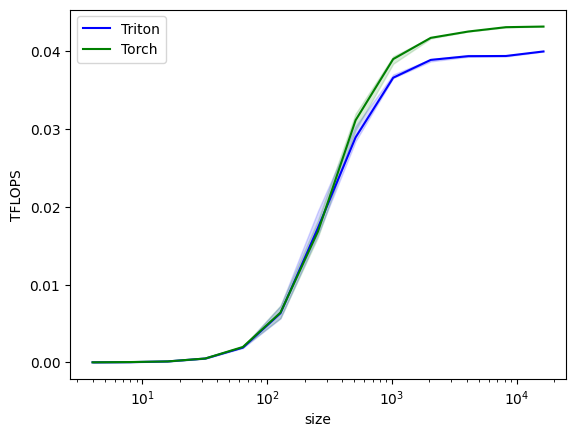

fused-relu-performance:
       size    Triton     Torch
0       4.0  0.000008  0.000008
1       8.0  0.000031  0.000043
2      16.0  0.000125  0.000125
3      32.0  0.000496  0.000500
4      64.0  0.001896  0.001984
5     128.0  0.006321  0.006400
6     256.0  0.017319  0.016856
7     512.0  0.028947  0.031148
8    1024.0  0.036612  0.039010
9    2048.0  0.038905  0.041743
10   4096.0  0.039386  0.042556
11   8192.0  0.039408  0.043114
12  16384.0  0.039992  0.043193


In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[1 << i for i in range(2, 15)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='TFLOPS',
        plot_name='fused-relu-performance',
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand((size, size), device='cuda', dtype=torch.float32)
    y = torch.rand((size, size), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]

    f = FusedReLU().cuda() if provider == 'torch' else f_triton
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: f(x, y), quantiles=quantiles)

    to_tflops = lambda ms: 2 * size * size * 1e-12 / (ms * 1e-3)
    return to_tflops(ms), to_tflops(max_ms), to_tflops(min_ms)


benchmark.run(print_data=True, show_plots=True)